In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import special, integrate, stats, interpolate, spatial, optimize, signal
import pickle
import corner
import pandas as pd
from matplotlib.colors import LogNorm
import healpy as hp
#if True:
#    import sys
#    sys.path.insert(0,'..')
#    sys.path.insert(0,'/usr/local/texlive/2018/bin/x86_64-darwin')
#    sys.path.insert(0,'/Library/TeX/texbin/latex')
#    import os
#    os.environ['PATH']+=':/Library/TeX/texbin/'
#    plt.rc('text', usetex=True)
#    plt.rc('font', family='serif')
#    plt.rc('xtick',labelsize=12)
#    plt.rc('ytick',labelsize=12)
import importlib
import tqdm
import emcee
#import matplotlib as mpl
#%config InlineBackend.figure_format = 'retina'
#mpl.rcParams['figure.dpi']= 150
import h5py

from numba.extending import get_cython_function_address
from numba import vectorize, njit
import ctypes
import numpy as np
import copy

addr = get_cython_function_address("scipy.special.cython_special", '__pyx_fuse_1erf')
functype = ctypes.CFUNCTYPE(ctypes.c_double, ctypes.c_double)
erf_fn = functype(addr)


@vectorize('float64(float64)')
def vec_erf(x):
    return erf_fn(x)

@njit
def erf_in_njit(x):
    return vec_erf(x)

@njit
def erf_in_njit_scalar(x):
    return erf_fn(x)

from math import log, exp, sqrt
import time

In [2]:
#times = np.load('../times_bin1_test.npy')
#matches = np.load('../matches_bin1_test.npy')

#with open('../times_matches_Gbin.p','rb') as f:
#    g_bins = pickle.load(f)

with open('deletions_box_stage_3.p','rb') as f:
    g_bins = pickle.load(f)

In [13]:
g_bins[0]

{'times': array([1666.43849537, 1666.43849537, 1666.43849537, ..., 2334.48328704,
        2334.48328704, 2334.48363426]),
 'mags': array([12.07305472, 12.47308779, 12.50238717, ..., 12.53019779,
         8.64850339, 11.1787122 ]),
 'errors': array([0.60979601, 0.25595012, 0.18828537, ..., 0.00098787, 0.10012182,
        0.25016851]),
 'successes': array([0., 0., 0., ..., 1., 0., 0.])}

In [14]:
times_glob = []
matches_glob = []
for i in range(len(g_bins)):
    #times0 = np.array([item for sublist in g_bins[i]['times'] for item in sublist])
    #indx = np.argsort(times0)
    #times0 = times0[indx]
    #matches0 = np.array([item for sublist in g_bins[i]['matches'] for item in sublist])[indx]
    times0 = g_bins[i]['times']
    indx = np.argsort(times0)
    times0 = times0[indx]
    matches0 = g_bins[i]['successes']
    times_glob.append(times0)
    matches_glob.append(matches0)

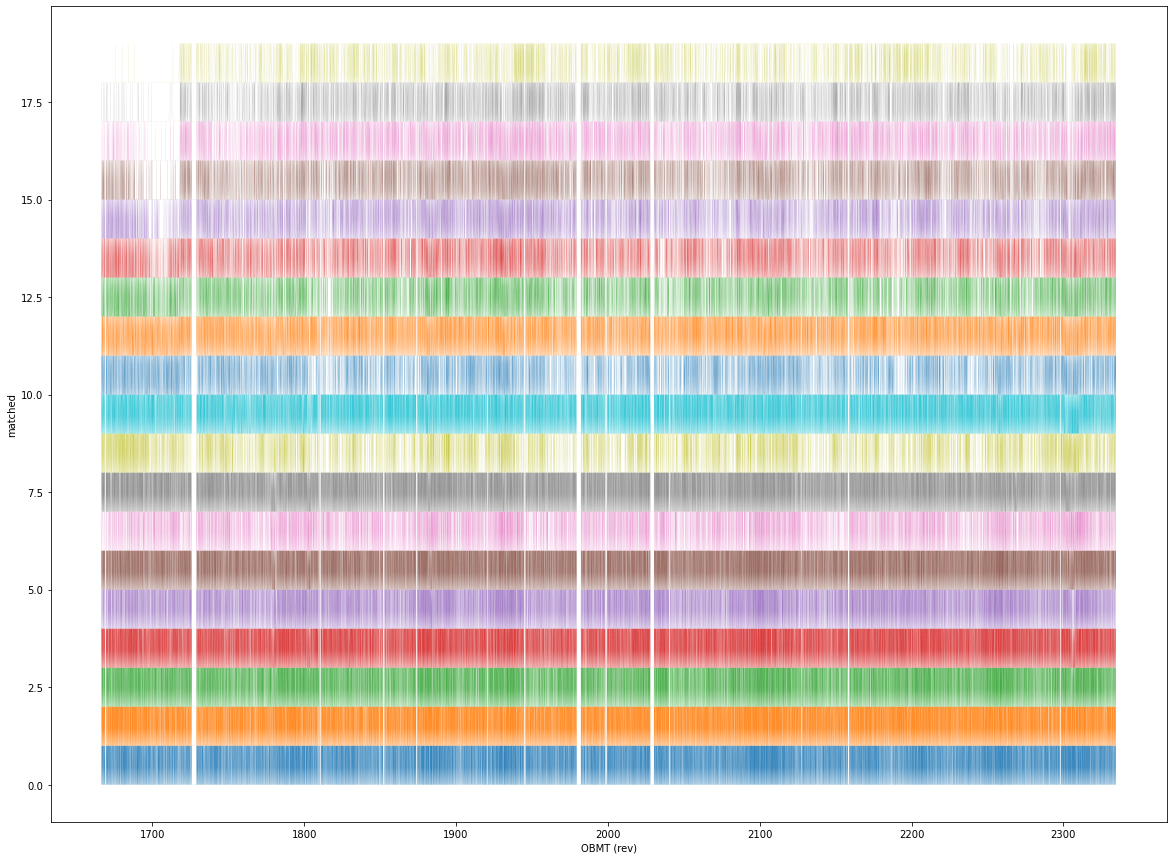

In [15]:
plt.figure(figsize = (20,15))
for i in range(len(times_glob)):
    plt.plot(times_glob[i],matches_glob[i]+i,lw = 0.05)
plt.xlabel('OBMT (rev)')
plt.ylabel('matched')
#plt.ylim(10,12)
#plt.xlim(1720,1740)
plt.show()

In [17]:
root2 = np.sqrt(2.0)
root2pi = np.sqrt(2.0*np.pi)

@njit
def x_to_delfrac(x):
    return 0.5*(1.0+erf_in_njit(x/root2))

@njit
def phiPhi(mu,sigma2):
    _phi = np.exp(-0.5*mu*mu/(1.0+sigma2))/root2pi/np.sqrt(1.0+sigma2)
    J0 = 0.5*(1.0+erf_in_njit(mu/(root2*np.sqrt(1.0+sigma2))))
    J1 = mu * J0 + sigma2 * _phi
    J2 = sigma2 * J0 + mu * J1 + ((mu*sigma2)/(1.0+sigma2)) * _phi
    #return J0, J1/J0, (J2 - J1*J1/J0)/J0
    return J0, J1, J2

@njit
def phiPhi_fast(mu,sigma2):
    root1sigma2 = sqrt(1.0+sigma2)
    _phi = exp(-0.5*mu**2/(1.0+sigma2))/root2pi/root1sigma2
    J0 = 0.5*(1.0+erf_in_njit_scalar(mu/(root2*root1sigma2)))
    J1 = mu * J0 + sigma2 * _phi
    J2 = sigma2 * J0 + mu * J1 + ((mu*sigma2)/(1.0+sigma2)) * _phi
    #return J0, J1/J0, (J2 - J1*J1/J0)/J0
    return J0, J1, J2

@njit
def likelihood_prior(success,p,mu,sigma2):
    
    if success == -1:
        m, s2, log_A = mu, sigma2, 0.0
    else:
        # These are the unnormalised central moments of Phi(x)*phi(x|mu,sigma2)
        J0, J1, J2 = phiPhi(mu,sigma2)
        if success == 1:
            I0, I1, I2 = p*J0, p*J1, p*J2
        else:
            I0, I1, I2 = 1.0 - p*J0, mu - p*J1, mu*mu + sigma2 - p*J2
        
        log_A = np.log(I0)
        m = I1/I0
        s2 = (I2 - I1*I1/I0)/I0
    return m, s2, log_A

@njit
def likelihood_prior_fast(success,p,mu,sigma2):
    
    # These are the unnormalised central moments of Phi(x)*phi(x|mu,sigma2)
    J0, J1, J2 = phiPhi_fast(mu,sigma2)
    
    flag_1 = 1.0-success
    flag_2 = p*(1.0-2.0*success)
    I0, I1, I2 = flag_1 * 1.0 - flag_2 * J0, flag_1 * mu - flag_2 * J1, flag_1 * (mu**2 + sigma2) - flag_2 * J2
        
    log_A = log(I0)
    m = I1/I0
    s2 = I2/I0 - m**2
    return m, s2, log_A

@njit
def forward_backward(times,successes,p,l,eps2,mu_prior,sigma2_prior,nu_prior,tau2_prior):
    
    M = times.size
    dtimes = np.diff(times)
    mu, sigma2, log_gamma = np.zeros(M), np.zeros(M), np.zeros(M)
    nu, tau2, log_delta = np.zeros(M), np.zeros(M), np.zeros(M)
    m, s2, log_A = np.zeros(M), np.zeros(M), np.zeros(M)
    
    exp_gp = np.exp(-dtimes/l)
    exp_gp2 = exp_gp*exp_gp
    mean_factor = exp_gp
    variance_factor = 1.0-exp_gp2
    
    # Forward step

    ### Initial
    mu[0], sigma2[0], log_gamma[0] = likelihood_prior(successes[0],p,mu_prior,sigma2_prior)

    ### Loop forwards
    for _idx in range(M-1):
        next_state_mean = mu[_idx]*exp_gp[_idx]
        next_state_variance = sigma2[_idx]*exp_gp2[_idx]+eps2*(1.0-exp_gp2[_idx])
        mu[_idx+1], sigma2[_idx+1], log_gamma[_idx+1] = likelihood_prior(successes[_idx+1],p,next_state_mean,next_state_variance)

    # Backward step

    ### Initial
    nu[M-1] = nu_prior
    tau2[M-1] = tau2_prior
    #delta[M-1] = np.sqrt(2.0*np.pi*tau2_prior)
    log_delta[M-1] = 0.5*np.log(2.0*np.pi*tau2_prior)

    ### Loop backwards
    for _idx in range(M-1,0,-1):
        m[_idx], s2[_idx], log_A[_idx] = likelihood_prior(successes[_idx],p,nu[_idx],tau2[_idx])

        #nu[_idx-1] = m[_idx]*exp_gp[_idx]
        #tau2[_idx-1] = s2[_idx]*exp_gp2[_idx]+eps2*(1.0-exp_gp2[_idx])
        nu[_idx-1] = m[_idx]*exp_gp[_idx-1]
        tau2[_idx-1] = s2[_idx]*exp_gp2[_idx-1]+eps2*(1.0-exp_gp2[_idx-1])
       
        log_delta[_idx-1] = log_A[_idx]+log_delta[_idx]-log_gamma[_idx]

    # Merge forward and backward
    kappa2 = 1.0/(1.0/sigma2 + 1.0/tau2)
    theta = (nu/sigma2 + mu/tau2)*kappa2

    log_likelihood = np.sum(log_gamma)
    
    return theta, kappa2, log_likelihood

@njit
def forward_likelihood(times,successes,p,l,eps2,mu_prior,sigma2_prior,nu_prior,tau2_prior):
    
    M = times.size
    dtimes = np.diff(times)
    mu,sigma2,log_likelihood = 0.0,0.0,0.0
     
    exp_gp = np.exp(-dtimes/l)
    exp_gp2 = exp_gp*exp_gp
    
    # Forward step

    ### Initial
    mu, sigma2, log_likelihood = likelihood_prior(successes[0],p,mu_prior,sigma2_prior)

    ### Loop forwards
    for _idx in range(M-1):
        #next_state_mean = mu*exp_gp[_idx]
        #next_state_variance = sigma2*exp_gp2[_idx]+eps2*(1.0-exp_gp2[_idx])
        #mu, sigma2, log_gamma = likelihood_prior(successes[_idx+1],p,next_state_mean,next_state_variance)
        mu, sigma2, log_gamma = likelihood_prior(successes[_idx+1],p,mu*exp_gp[_idx],sigma2*exp_gp2[_idx]+eps2*(1.0-exp_gp2[_idx]))
        log_likelihood += log_gamma
    
    return log_likelihood

@njit
def viterbi(K,M,log_pi,log_A,log_B):

    lnL = 0.0
    
    log_T1 = np.zeros((M,K))
    T2 = np.zeros((M,K))
    z = np.zeros(M)

    log_T1[0] = log_pi+log_B[0]
            
    for j in range(1,M):
        _values_0 = log_T1[j-1,:] + log_A[:,0] + log_B[j,0]
        _argmax = np.argmax(_values_0)
        log_T1[j,0] = _values_0[_argmax]
        T2[j,0] = _argmax
        
        _values_1 = log_T1[j-1,:] + log_A[:,1] + log_B[j,1]
        _argmax = np.argmax(_values_1)
        log_T1[j,1] = _values_1[_argmax]
        T2[j,1] = _argmax
        
        lnL += np.logaddexp(np.logaddexp(_values_0[0],_values_0[1]),np.logaddexp(_values_1[0],_values_1[1]))

    z[-1] = np.argmax(log_T1[-1,:])

    for j in range(M-1,0,-1):
        z[j-1] = T2[j,int(z[j])]
        
    return lnL,z

@njit
def likelihood_viterbi(K,M,log_pi,log_A,log_B):

    lnL = 0.0
    
    log_T1 = np.zeros((M,K))

    log_T1[0] = log_pi+log_B[0]
            
    for j in range(1,M):
        _values_0 = log_T1[j-1,:] + log_A[:,0] + log_B[j,0]
        _argmax = np.argmax(_values_0)
        log_T1[j,0] = _values_0[_argmax]
    #    T2[j,0] = _argmax
        
        _values_1 = log_T1[j-1,:] + log_A[:,1] + log_B[j,1]
        _argmax = np.argmax(_values_1)
        log_T1[j,1] = _values_1[_argmax]
    #    T2[j,1] = _argmax
        
        lnL += np.logaddexp(np.logaddexp(_values_0[0],_values_0[1]),np.logaddexp(_values_1[0],_values_1[1]))

    #z[-1] = np.argmax(log_T1[-1,:])

    #for j in range(M-1,0,-1):
    #    z[j-1] = T2[j,int(z[j])]
        
    return lnL

@njit
def continuous_viterbi(K,M,log_pi,log_A,log_B):

    lnL = 0.0
    
    log_T1 = np.zeros((M,K))
    T2 = np.zeros((M,K))
    z = np.zeros(M)

    log_T1[0] = log_pi+log_B[0]
            
    for j in range(1,M):
        _values_0 = log_T1[j-1,:] + log_A[:,0,j-1] + log_B[j,0]
        _argmax = np.argmax(_values_0)
        log_T1[j,0] = _values_0[_argmax]
        T2[j,0] = _argmax
        
        _values_1 = log_T1[j-1,:] + log_A[:,1,j-1] + log_B[j,1]
        _argmax = np.argmax(_values_1)
        log_T1[j,1] = _values_1[_argmax]
        T2[j,1] = _argmax
        
        lnL += np.logaddexp(np.logaddexp(_values_0[0],_values_0[1]),np.logaddexp(_values_1[0],_values_1[1]))

    z[-1] = np.argmax(log_T1[-1,:])

    for j in range(M-1,0,-1):
        z[j-1] = T2[j,int(z[j])]
        
    return lnL,z

@njit
def quadlogaddexp(x0,x1,x2,x3,x_max):
    return x_max+log(exp(x0-x_max)+exp(x1-x_max)+exp(x2-x_max)+exp(x3-x_max))


@njit
def likelihood_continuous_viterbi(K,M,log_pi,log_A,log_B):

    lnL = 0.0

    log_T1_0 = log_pi[0]+log_B[0,0]
    log_T1_1 = log_pi[1]+log_B[0,1]
            
    for j in range(1,M):
        _values_0_0 = log_T1_0 + log_A[0,0,j-1] + log_B[j,0]
        _values_0_1 = log_T1_1 + log_A[1,0,j-1] + log_B[j,0]
        
        _values_1_0 = log_T1_0 + log_A[0,1,j-1] + log_B[j,1]
        _values_1_1 = log_T1_1 + log_A[1,1,j-1] + log_B[j,1]
        
        log_T1_0 = max(_values_0_0,_values_0_1)
        log_T1_1 = max(_values_1_0,_values_1_1)
        
        max_value = max(log_T1_0,log_T1_1)
        
        lnL += quadlogaddexp(_values_0_0,_values_0_1,_values_1_0,_values_1_1,max_value)
        
    return lnL

def get_gap_list(nums):
    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

@njit
def nll_viterbi(x,*args):
    #logit_p,logit_F,log_q,log_r = x
    logit_p,log_q,log_r = x
    _F = 0.5
    global_successes,dt,log_pi,log_A,log_B = args
    
    _p,_q,_r = 1.0/(1.0+exp(-logit_p)),exp(log_q),exp(log_r)
    #_p,_F,_q,_r = 1.0/(1.0+exp(-logit_p)),1.0/(1.0+exp(-logit_F)),exp(log_q),exp(log_r)
    log_p, log_1_p = log(_p), log(1.0-_p)
    log_F, log_1_F = log(_F), log(1.0-_F)
    
    
    D_r = _F*(1.0-np.exp(-dt/_r))
    D_q = (1.0-_F)*(1.0-np.exp(-dt/_q))
    #log_A[0,0] = np.log(1.0-D_r)
    #log_A[0,1] = np.log(D_q)
    #log_A[1,0] = np.log(D_r)
    #log_A[1,1] = np.log(1.0-D_q)
    log_A[0,0] = np.log(1.0-D_r)
    log_A[0,1] = np.log(D_r)
    log_A[1,0] = np.log(D_q)
    log_A[1,1] = np.log(1.0-D_q)

    
    log_B[global_successes<0.5,0] = 0.0
    log_B[global_successes>0.5,0] = -np.inf

    log_B[global_successes<0.5,1] = log_1_p
    log_B[global_successes>0.5,1] = log_p

    log_likelihood = likelihood_continuous_viterbi(K,M,log_pi,log_A,log_B)
    
    # This is the logistic prior
    log_prior = log_p + log_1_p + log_F + log_1_F 
    
    print(-(log_likelihood + log_prior),x)
    
    return -(log_likelihood + log_prior)

In [18]:
# To take into account when different magnitude bins are mixed. NOT FOR THE MOMENT (only 5 < G < 13)

sp_bins = np.array([5,13,16,16.3,17.0,17.2,18.0,18.1,
                   19,19.05,19.95,20.0,20.3,20.4,20.5,
                   20.6,20.7,20.8,20.9,21.0])
N_sp = sp_bins.size-1
F_deletion = np.array([0,0,1,1,2,2,2,2,2,7,2,13,12,13,29,28,28,29,24])/100

sp_labels = ['SP1-'+str(_idx+1) for _idx in range(N_sp)]
g_labels = ['%5.2f'%(sp_bins[_idx]) for _idx in range(N_sp+1)]

In [19]:
# Same than before with multiple magnitude bins

inplay = np.arange(N_sp)

global_times = np.concatenate([times_glob[_idx] for _idx in inplay])
global_successes = np.concatenate([matches_glob[_idx] for _idx in inplay])
global_spins = np.concatenate([np.repeat(_idx,times_glob[_idx].size) for _idx in inplay])

global_timesort = np.argsort(global_times)
global_times = global_times[global_timesort]
global_dtimes = np.diff(global_times)
global_successes = global_successes[global_timesort]
global_spins = global_spins[global_timesort]
unpack_box = {}
for _idx in inplay:
    unpack_box[_idx] = np.where(global_spins == _idx)
M = global_times.size

In [20]:
K = 2

_p,_q,_r,_F = 0.7,0.9,0.01,0.9

log_p, log_1_p = np.log(_p), np.log(1.0-_p)
log_q, log_1_q = np.log(_q), np.log(1.0-_q)
log_r, log_1_r = np.log(_r), np.log(1.0-_r)
log_F = np.log(_F)

dt = np.diff(global_times)# for only one bin: np.diff(times)
D_r = 1.0-np.exp(-dt/_r)
D_q = 1.0-np.exp(-dt/_q)
A = np.zeros((2,2,M-1))
A[0,0] = 1.0-D_r
A[0,1] = D_r
A[1,0] = D_q
A[1,1] = 1.0-D_q
log_A = np.log(A)

log_pi = np.array([np.log(0.5),np.log(0.5)])
log_B = np.zeros((M,K))
log_B[global_successes<0.5,0] = 0.0   # if only one bin: global_successes -> matches
log_B[global_successes>0.5,0] = -np.inf

log_B[global_successes<0.5,1] = log_1_p
log_B[global_successes>0.5,1] = log_p
    
%time log_likelihood, global_gaps = continuous_viterbi(K,M,log_pi,log_A,log_B)
print(log_likelihood)

%time log_likelihood = likelihood_continuous_viterbi(K,M,log_pi,log_A,log_B)
print(log_likelihood)

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/1589323743.py:18: RuntimeWarning: divide by zero encountered in log
  log_A = np.log(A)


CPU times: user 5.59 s, sys: 230 ms, total: 5.82 s
Wall time: 5.84 s
-80323216975513.4
CPU times: user 607 ms, sys: 5 ms, total: 612 ms
Wall time: 613 ms
-80323216975513.4


In [21]:
dt = np.diff(global_times)  #if only one bin: global_times -> times
log_pi = np.array([np.log(0.5),np.log(0.5)])
log_A = np.zeros((2,2,M-1))
log_B = np.zeros((M,K))
args = (global_successes,dt,log_pi,log_A,log_B)   # if only one bin: global_successes -> matches
x = np.array([2.0,0.0,0.0])
%time nll_viterbi(x,*args)

55379014093277.07 [2. 0. 0.]
CPU times: user 1.98 s, sys: 196 ms, total: 2.18 s
Wall time: 2.18 s


55379014093277.07

In [22]:
%time res = optimize.minimize(nll_viterbi,x0=np.array([2.0,-1.0,-1.0]),method='nelder-mead',args=args,options={'maxfev':1e4,'adaptive':False,'xatol':1e-2,'fatol':1e-2})

55378527122903.69 [ 2. -1. -1.]
54813730192555.83 [ 2.1 -1.  -1. ]
55378824348526.9 [ 2.   -1.05 -1.  ]
55378379465199.37 [ 2.   -1.   -1.05]
54980695955122.62 [ 2.06666667 -0.95       -1.03333333]
54762117171248.8 [ 2.11111111 -0.96666667 -1.05555556]
54538738595489.41 [ 2.16666667 -0.95       -1.08333333]
54369026659614.91 [ 2.22222222 -0.93333333 -1.02777778]
54180213328002.77 [ 2.33333333 -0.9        -1.01666667]
54180378588271.914 [ 2.33333333 -0.95       -1.03333333]
54187083146193.71 [ 2.45555556 -0.86666667 -1.08888889]
54407903985656.83 [ 2.58148148 -0.86111111 -1.00925926]
54211208718947.695 [ 2.47777778 -0.88333333 -1.02777778]
54263085969063.234 [ 2.27037037 -0.92777778 -1.06481481]
54166125261467.49 [ 2.42592593 -0.89444444 -1.03703704]
54259162079273.234 [ 2.27283951 -0.96296296 -0.9691358 ]
54159595603162.35 [ 2.40987654 -0.89074074 -1.05895062]
54179061630502.57 [ 2.44609053 -0.84012346 -1.04176955]
54276557778179.94 [ 2.521262   -0.85020576 -1.07517147]
54157425516166.

54149573483138.84 [ 2.38530727  0.03053819 -3.13700243]
54149937796042.53 [ 2.39267996 -0.4945433  -2.87079233]
54149514896551.82 [ 2.39890185 -0.18783049 -3.39838183]
54149282184279.57 [ 2.3881324   0.13111825 -3.82011677]
54149508761408.29 [ 2.39738851 -0.32690985 -4.00931623]
54149896435851.19 [ 2.38278504 -0.20126074 -4.15522643]
54149020154360.82 [ 2.39487265 -0.19118806 -3.58759298]
54149632054875.46 [ 2.38262114  0.02829981 -3.2631432 ]
54149005572495.15 [ 2.39369667 -0.23810744 -3.82277297]
54149445806111.72 [ 2.39558676 -0.67587876 -3.45411346]
54148950516071.69 [ 2.38999599 -0.070631   -3.72861594]
54149013174348.734 [ 2.3855954  -0.27320107 -3.78065256]
54148887023770.59 [ 2.38791471 -0.25269782 -3.73238766]
54149227129625.8 [ 2.38291675 -0.23600861 -3.4852157 ]
54148868512301.77 [ 2.39100169 -0.23758273 -3.73838365]
54148977862150.04 [ 2.38728789 -0.51478621 -3.58588453]
54148866364579.945 [ 2.38931896 -0.1816698  -3.69293309]
54149203747504.15 [ 2.39181416 -0.06012164 -3.9

54148825877051.305 [ 2.39000109 -0.29212878 -3.62262703]
54148825861049.766 [ 2.39000109 -0.29212905 -3.62262674]
54148825863842.125 [ 2.39000109 -0.29212904 -3.62262684]
54148825859479.57 [ 2.39000109 -0.29212892 -3.62262685]
54148825869084.6 [ 2.39000109 -0.29212909 -3.62262676]
54148825866937.46 [ 2.39000109 -0.29212891 -3.62262695]
54148825863882.25 [ 2.39000109 -0.29212895 -3.6226269 ]
54148825870278.4 [ 2.39000109 -0.29212905 -3.62262681]
54148825865467.25 [ 2.39000109 -0.29212898 -3.62262688]
54148825867501.39 [ 2.39000109 -0.29212898 -3.62262686]
54148825868109.74 [ 2.39000109 -0.29212904 -3.62262686]
54148825868027.54 [ 2.39000109 -0.292129   -3.62262689]
54148825869663.59 [ 2.39000109 -0.29212897 -3.62262689]
54148825868611.23 [ 2.39000109 -0.29212902 -3.62262686]
54148825869588.42 [ 2.39000109 -0.29212901 -3.62262687]
54148825872913.734 [ 2.39000109 -0.29212902 -3.62262688]
54148825872862.2 [ 2.39000109 -0.29212904 -3.62262686]
54148825873324.17 [ 2.39000109 -0.29212904 -3.6

54148825848487.21 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.24 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.24 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.25 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.24 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.21 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.24 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.24 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.24 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.21 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.24 [ 2.39000109 -0.29212905 -3.62262686]
54148825848487.21 [ 2.39000109 -0.29212905 -3.62262686]
CPU times: user 9min 33s, sys: 26.3 s, total: 9min 59s
Wall time: 9min 59s


In [23]:
res

 final_simplex: (array([[ 2.39000109, -0.29212905, -3.62262686],
       [ 2.39000109, -0.29212905, -3.62262686],
       [ 2.39000109, -0.29212905, -3.62262686],
       [ 2.39000109, -0.29212905, -3.62262686]]), array([5.41488258e+13, 5.41488258e+13, 5.41488258e+13, 5.41488258e+13]))
           fun: 54148825848487.21
       message: 'Optimization terminated successfully.'
          nfev: 456
           nit: 214
        status: 0
       success: True
             x: array([ 2.39000109, -0.29212905, -3.62262686])

In [24]:
logit_p,log_q,log_r = res.x#np.array([ 2.75636229, -2.13152669, -5.35128118])#res.x
_F = 0.5
_p,_q,_r = 1.0/(1.0+exp(-logit_p)),exp(log_q),exp(log_r)


global_successes,dt,log_pi,log_A,log_B = args    #if one bin: global_successes -> matches


print(_p,_F,_q,_r)
log_p, log_1_p = log(_p), log(1.0-_p)
log_F, log_1_F = log(_F), log(1.0-_F)


D_r = _F*(1.0-np.exp(-dt/_r))
D_q = (1.0-_F)*(1.0-np.exp(-dt/_q))
log_A[0,0] = np.log(1.0-D_r)
log_A[0,1] = np.log(D_r)
log_A[1,0] = np.log(D_q)
log_A[1,1] = np.log(1.0-D_q)


log_B[global_successes<0.5,0] = 0.0            #if one bin: global_successes -> matches
log_B[global_successes>0.5,0] = -np.inf

log_B[global_successes<0.5,1] = log_1_p
log_B[global_successes>0.5,1] = log_p

%time log_likelihood, global_gaps = continuous_viterbi(K,M,log_pi,log_A,log_B)

0.9160616521251187 0.5 0.7466721726652068 0.026712414450881756


/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/1344761791.py:17: RuntimeWarning: divide by zero encountered in log
  log_A[0,1] = np.log(D_r)
/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/1344761791.py:18: RuntimeWarning: divide by zero encountered in log
  log_A[1,0] = np.log(D_q)


CPU times: user 5.18 s, sys: 121 ms, total: 5.3 s
Wall time: 5.3 s


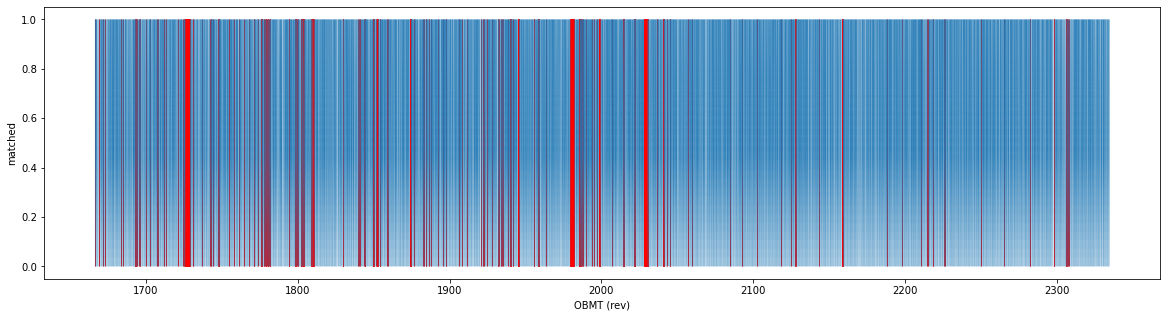

In [25]:
gap_list = get_gap_list(np.where(global_gaps<0.5)[0])
plt.figure(figsize = (20,5))
plt.plot(global_times,global_successes,lw = 0.05)     #if one bin: global_successes -> matches; global_times -> times
for _start,_end in gap_list:
    plt.fill_between([global_times[_start],global_times[_end]],y1=[0,0],y2=[1,1],color = 'r')
#plt.scatter(global_times,global_gaps,s=1)
plt.xlabel('OBMT (rev)')
plt.ylabel('matched')
#plt.xlim(1666.4,1666.5)
plt.show()

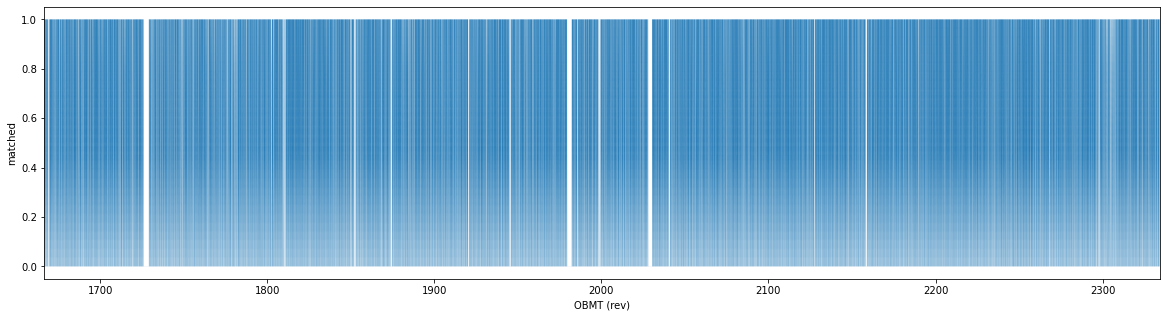

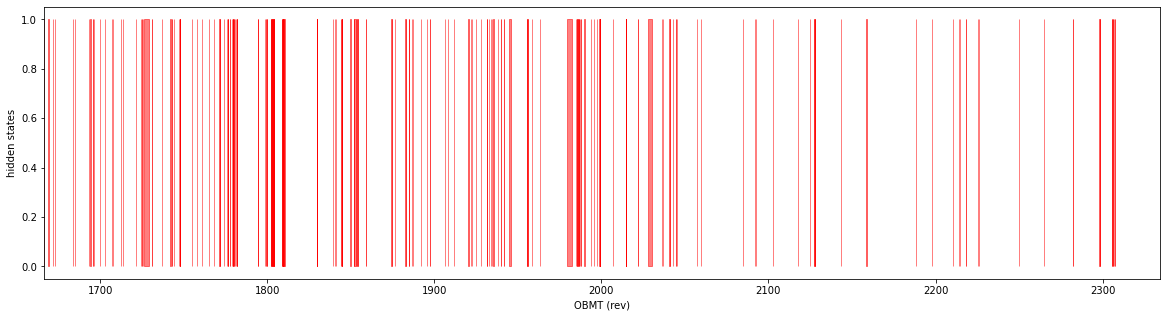

In [26]:
plt.figure(figsize = (20,5))
plt.plot(global_times,global_successes,lw = 0.05)
plt.xlabel('OBMT (rev)')
plt.ylabel('matched')
plt.xlim(global_times[0],global_times[-1])
plt.show()
plt.figure(figsize = (20,5))
for _start,_end in gap_list:
    plt.fill_between([global_times[_start],global_times[_end]],y1=[0,0],y2=[1,1],color = 'r',alpha = 0.5)
plt.xlabel('OBMT (rev)')
plt.ylabel('hidden states')
plt.xlim(global_times[0],global_times[-1])
plt.show()

In [27]:
# Deletion with fixed local gaps

In [28]:
# Iterate

In [29]:
import copy
import time
n_inplay = inplay.size # only one bin for the moment. Otherwise: inplay.size
K = 2
M = global_times.size
N_loop = 11
mu_prior = -3.0
sigma2_prior = 36.0
nu_prior = -3.0
tau2_prior = 36.0

reports = {}
reports['q'] = [1.0]*N_loop
reports['r'] = [1.0]*N_loop
for _idx in inplay: # only one bin now. Otherwise: inplay:
    reports['local_fractions_mean_'+str(_idx)] = [np.ones(np.array(times_glob[_idx]).size)]*N_loop
    reports['local_fractions_variance_'+str(_idx)] = [np.ones(np.array(times_glob[_idx]).size)]*N_loop
    reports['l_'+str(_idx)] = [1.0]*N_loop
    reports['eps2_'+str(_idx)] = [1.0]*N_loop
reports['global_gaps'] = [np.ones(global_times.size)]*N_loop

# Local gaps
@njit
def nll_step1(x,*args):
    #logit_p,logit_F,log_q,log_r = x
    log_l,log_eps2 = x
    _p,_l,_eps2 = 1.0,exp(log_l),exp(log_eps2)
    _times,_successes,mu_prior,sigma2_prior,nu_prior,tau2_prior = args
    
    log_likelihood = forward_likelihood(_times,_successes,_p,_l,_eps2,mu_prior,sigma2_prior,nu_prior,tau2_prior)
    
    # No prior needed
    log_prior = 0.0# 1.0/eps2
    #print(-(log_likelihood + log_prior),x)
    
    return -(log_likelihood + log_prior)

@njit
def sequence_step1(_l,_eps2,args):
    _times,_successes,mu_prior,sigma2_prior,nu_prior,tau2_prior = args
    theta, kappa2, log_likelihood = forward_backward(_times,_successes,1.0,_l,_eps2,mu_prior,sigma2_prior,nu_prior,tau2_prior)
    
    return theta, kappa2

# Global gaps
@njit
def nll_step2(x,*args):
    log_q,log_r = x
    _F = 0.5
    global_successes,dt,log_pi,log_A,log_B = args
    
    _q,_r = exp(log_q),exp(log_r)
    
    D_r = _F*(1.0-np.exp(-dt/_r))
    D_q = (1.0-_F)*(1.0-np.exp(-dt/_q))
    log_A[0,0] = np.log(1.0-D_r)
    log_A[0,1] = np.log(D_r)
    log_A[1,0] = np.log(D_q)
    log_A[1,1] = np.log(1.0-D_q)


    log_likelihood = likelihood_continuous_viterbi(K,M,log_pi,log_A,log_B)
    
    # This is the logistic prior
    log_prior = 0.0
    
    #print(-(log_likelihood + log_prior),x)
    
    return -(log_likelihood + log_prior)

@njit
def sequence_step2(_q,_r,args):
    
    _F = 0.5
    global_successes,dt,log_pi,log_A,log_B = args
    
    D_r = _F*(1.0-np.exp(-dt/_r))
    D_q = (1.0-_F)*(1.0-np.exp(-dt/_q))
    log_A[0,0] = np.log(1.0-D_r)
    log_A[0,1] = np.log(D_r)
    log_A[1,0] = np.log(D_q)
    log_A[1,1] = np.log(1.0-D_q)
    
    return continuous_viterbi(K,M,log_pi,log_A,log_B)[1]

for _loop in range(1,N_loop):
    
    print('On loop',_loop,'out of',N_loop-1)
    # Second step - fit the whole thing, holding the p's and q's constant
    t0 = time.time()
    log_pi = np.array([np.log(0.5),np.log(0.5)])
    log_A = np.zeros((2,2,M-1))
    log_B = np.zeros((global_times.size,2))
    p = x_to_delfrac(np.concatenate([reports['local_fractions_mean_'+str(_idx)][_loop-1] for _idx in inplay])[global_timesort])
    _success = global_successes>0.5
    log_B[~_success,0] = 0.0
    log_B[_success,0] = -np.inf
    log_B[~_success,1] = np.log(1.0-p[~_success]+1e-16)
    log_B[_success,1] = np.log(p[_success]+1e-16)

    initial = np.array([np.log(reports['q'][_loop-1]),np.log(reports['r'][_loop-1])])
    args = (global_successes,global_dtimes,log_pi,log_A,log_B)
    soln = optimize.minimize(nll_step2, initial, args=args, method = 'Nelder-Mead', options={'maxfev':1e4,'adaptive':False,'xatol':1e-2,'fatol':1e+2})
    reports['q'][_loop],reports['r'][_loop] = np.exp(soln.x)
    reports['global_gaps'][_loop] = sequence_step2(reports['q'][_loop],reports['r'][_loop],args)
    t1 = time.time()
    print('Took',t1-t0,'seconds to complete step2')
    
    # First step - fit each individual magnitude bin
    for _idx in tqdm.tqdm_notebook(inplay):
        
        #print('prepare')
        local_gaps = reports['global_gaps'][_loop-1][unpack_box[_idx]]
        local_times = copy.copy(np.array(times_glob[_idx]))
        local_successes = copy.copy(np.array(matches_glob[_idx]))
        local_successes[local_gaps == 0.0] = -1
        args = (local_times,local_successes,mu_prior,sigma2_prior,nu_prior,tau2_prior)
        #print('optimize')
        initial = np.array([np.log(reports['l_'+str(_idx)][_loop-1]),np.log(reports['eps2_'+str(_idx)][_loop-1])])
        soln = optimize.minimize(nll_step1, initial, args=args, method = 'Nelder-Mead', options={'maxfev':1e4,'adaptive':False,'xatol':1e-2,'fatol':1e-2})
        reports['l_'+str(_idx)][_loop], reports['eps2_'+str(_idx)][_loop] = np.exp(soln.x)
        #print('finalize')
        # Generate ML sequence
        reports['local_fractions_mean_'+str(_idx)][_loop], reports['local_fractions_variance_'+str(_idx)][_loop] = sequence_step1(reports['l_'+str(_idx)][_loop], reports['eps2_'+str(_idx)][_loop], args)



On loop 1 out of 10
Took 235.5249559879303 seconds to complete step2


/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/2574038049.py:110: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(inplay):


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 2 out of 10
Took 163.79771208763123 seconds to complete step2


/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/2574038049.py:110: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(inplay):


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 3 out of 10
Took 120.41951322555542 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 4 out of 10
Took 80.58575415611267 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 5 out of 10
Took 119.5362548828125 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 6 out of 10
Took 123.06640481948853 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 7 out of 10
Took 122.08809018135071 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 8 out of 10
Took 116.28600811958313 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 9 out of 10
Took 61.03655195236206 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

On loop 10 out of 10
Took 108.57217311859131 seconds to complete step2


  0%|          | 0/19 [00:00<?, ?it/s]

In [30]:
reports['q'],reports['r']

([1.0,
  1.0299156119629074,
  1.263031540556607,
  1.2166007850138005,
  1.2241028370996305,
  1.2154108613529528,
  1.2234157593787893,
  1.2158389073309666,
  1.2231026812313464,
  1.2163432634168696,
  1.2234518926055704],
 [1.0,
  0.036763045207215565,
  0.04487123963844133,
  0.04329969569322667,
  0.043586165553421596,
  0.043338788444143364,
  0.043594253692684826,
  0.043326790011774204,
  0.04363107866050166,
  0.043344566243352,
  0.043573600921280486])

In [33]:
for i in inplay:
    print(reports['l_'+str(i)][-1],reports['eps2_'+str(i)][-1])

149.97499985085605 2.3349850144223474
1.566996634293015 2.484015256291492
9.624067389715652 2.172752107143577
1.783519494408926 2.3127387385038514
7.016972835795047 2.3023189775786683
2.1389737595613756 2.3038072041930007
11.042467771276026 2.2719917769245663
2.0042770877795903 2.0645854489900715
7.008047846645999 1.7094266853711633
0.2795885545071595 1.4617667955910616
7.818935837787398 1.003621195682178
1.3930643817487878 0.9745164242646462
2.314707488732811 1.16683651676349
2.2211931768473825 1.145793887608974
2.4980140434217413 1.048849153594839
3.003183114256797 0.9506662016365423
8.803135950443435 0.7080306469383064
19.623603109582554 0.5292465551587193
14.881254676089046 0.4007960983364424


In [34]:
np.exp(soln.x)

array([14.88125468,  0.4007961 ])

In [35]:
for _idx in range(1,11):
    _gaps = get_gap_list(np.where(reports['global_gaps'][_idx]<0.5)[0])
    print(len(_gaps))

248
199
206
205
206
205
206
205
206
205


In [36]:
_length = np.array([_end-_start for _start,_end in _gaps])
_length

array([15066,    57,  3452,  2193,    25,  2223,  2195,    41,    35,
          63,    30,     9,   118,   168,  3720,    37,   205,   131,
         251,     7,   484, 61650,   458,   342,    23,   687,   932,
          23,   524,  3825,   144,    18,    32,   807,   250,    25,
          46,   698,     8,    84,     5,   998,   164,   617,   177,
           9,    24,  3431,   234,   617,   268,  1056,   364,  3850,
         182,    15,    17,    45,    23,    13,    45,    10,     8,
          51,    20,    85,    84,    14,    23,    65,    82,    18,
          35,    36,    84,    39,   101,   104,    14,  3245,   845,
       12431,   477,  2729,   756,   388,    88,    19,    18,    18,
          81,    99,    60,    29,    32,    43,  4240,    33,    87,
       12599,    13,   372,  2324,   124,    40, 25366,    47,   971,
        4932,   641,  4044,    25,   137,   460,  1090,    42,    20,
           9,    43,    30,   501, 27529,  2721,   456,  2400,    40,
        4715,   524,

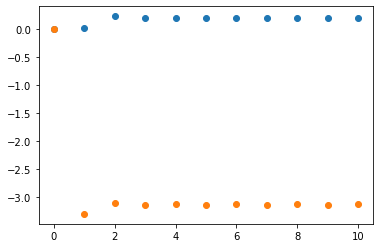

In [37]:
plt.scatter(range(N_loop),np.log(np.array([reports['q'][_loop] for _loop in range(N_loop)])))
plt.scatter(range(N_loop),np.log(np.array([reports['r'][_loop] for _loop in range(N_loop)])))

In [38]:
rox = {k:v[N_loop-1] for k,v in reports.items()}

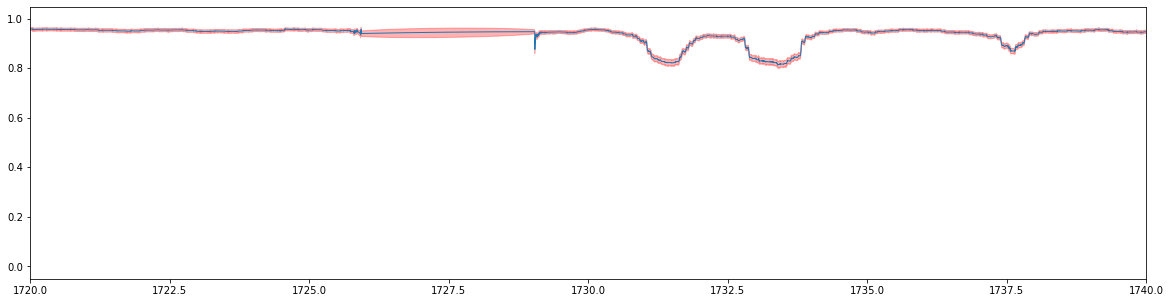

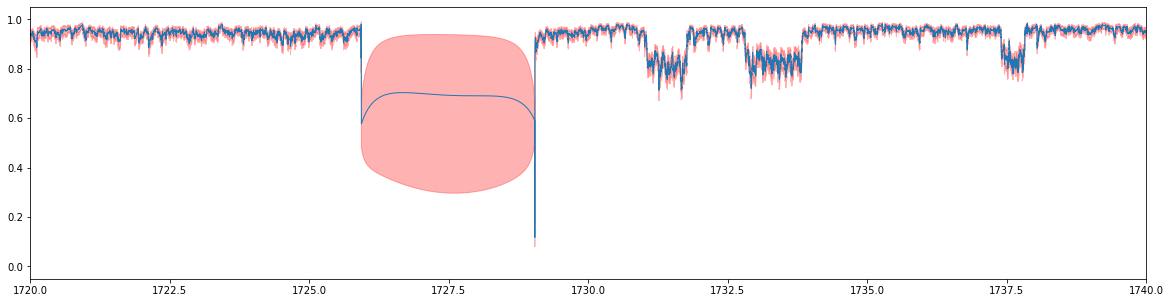

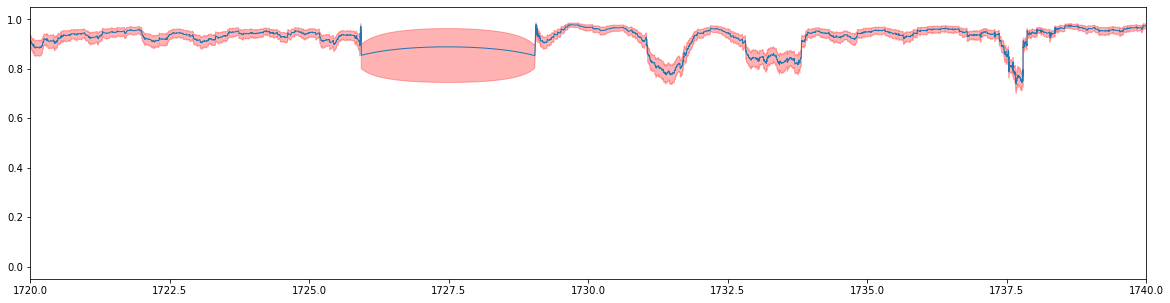

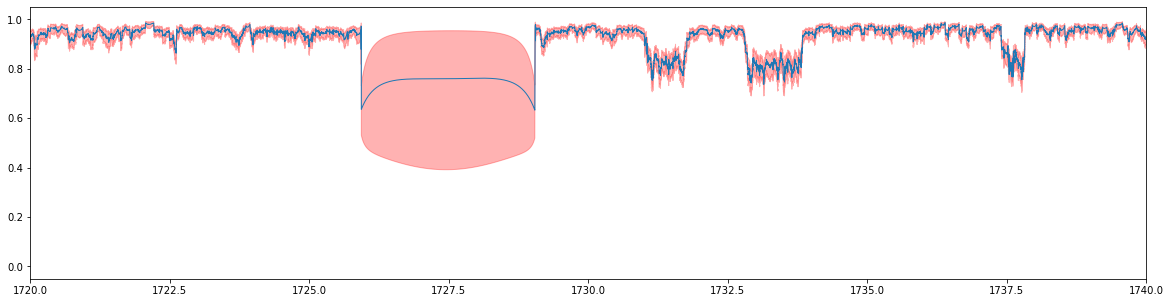

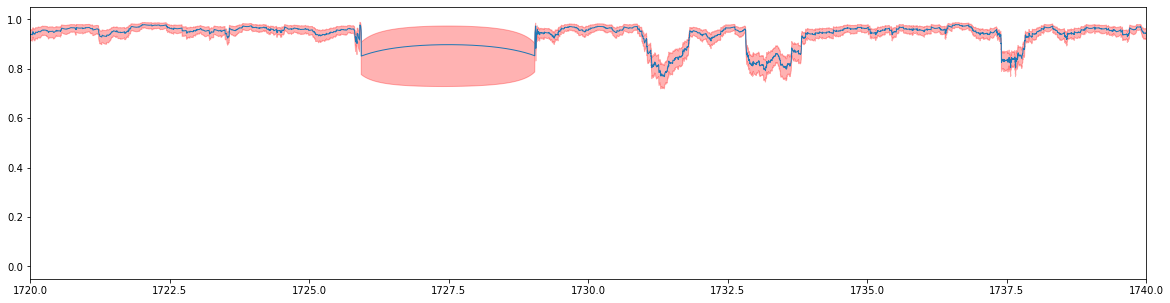

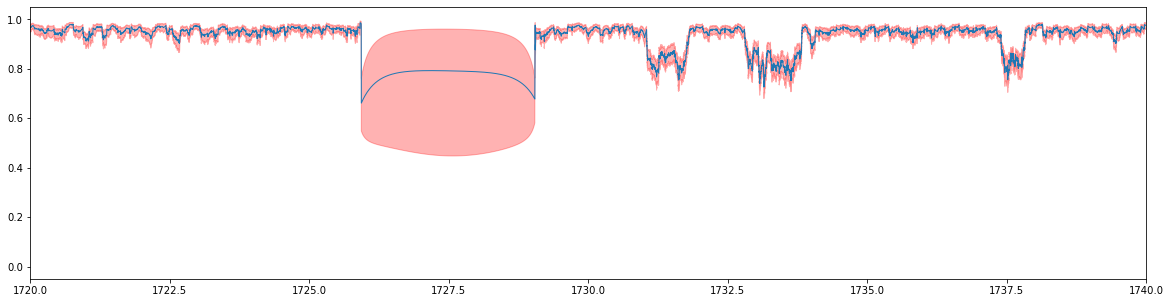

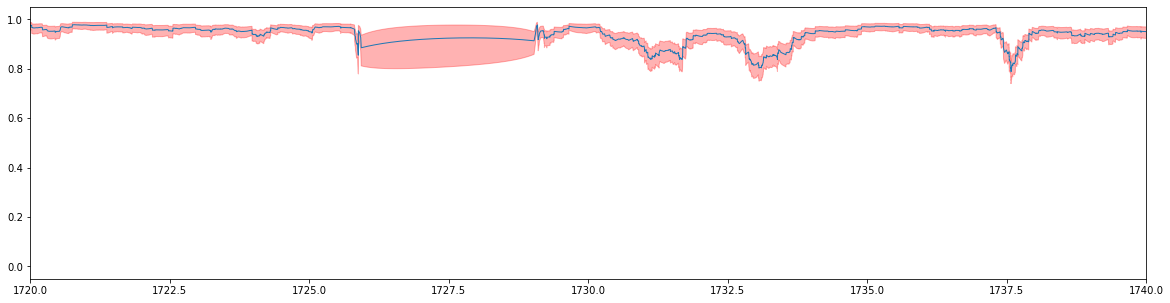

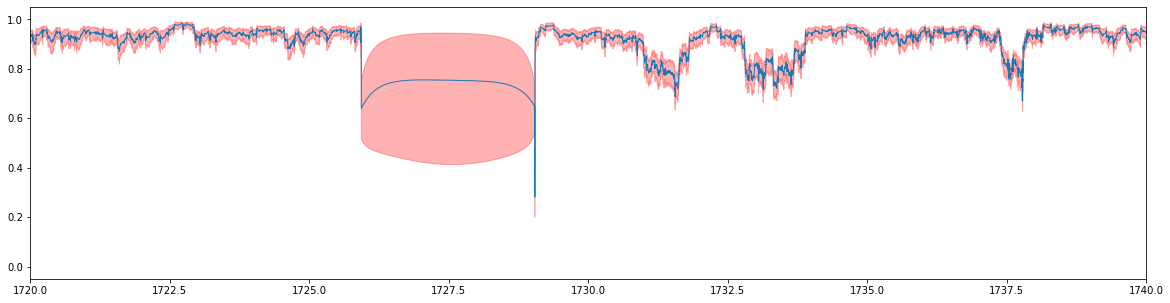

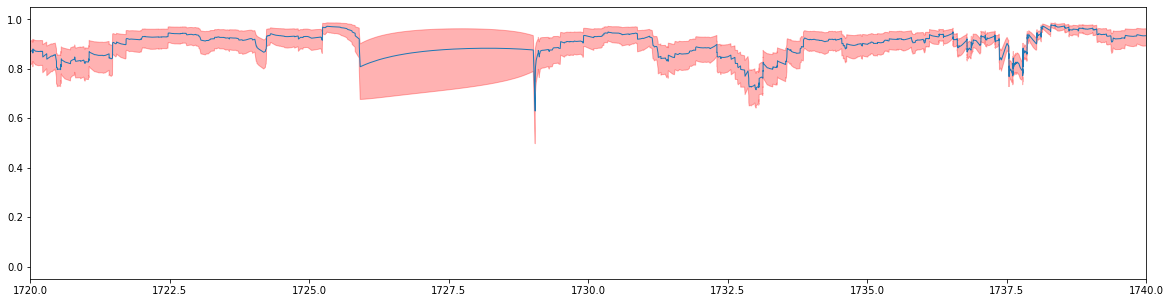

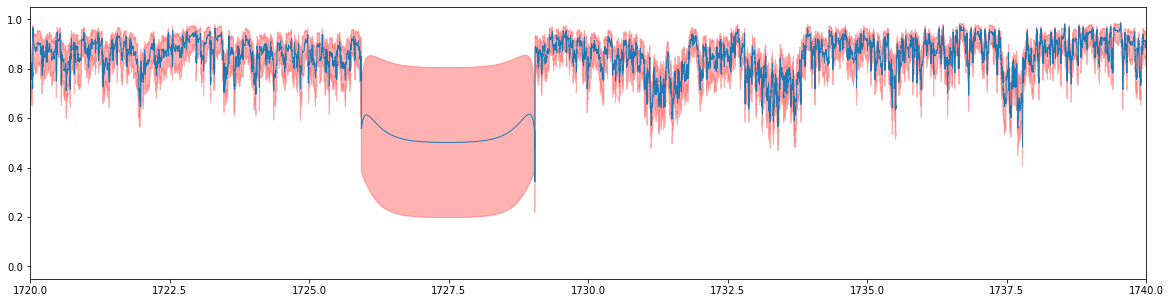

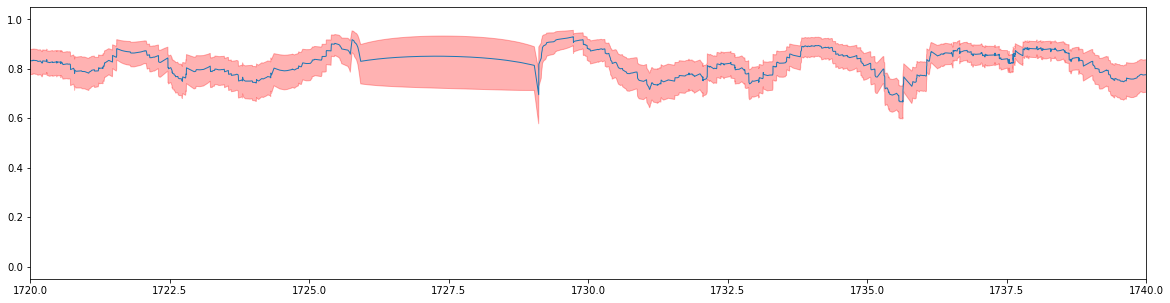

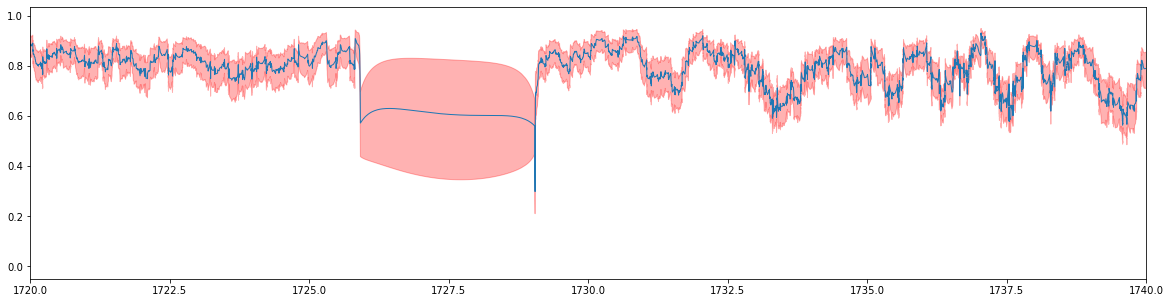

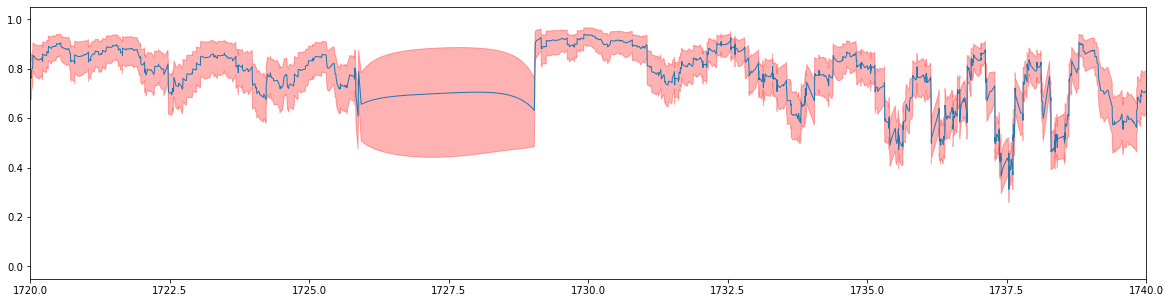

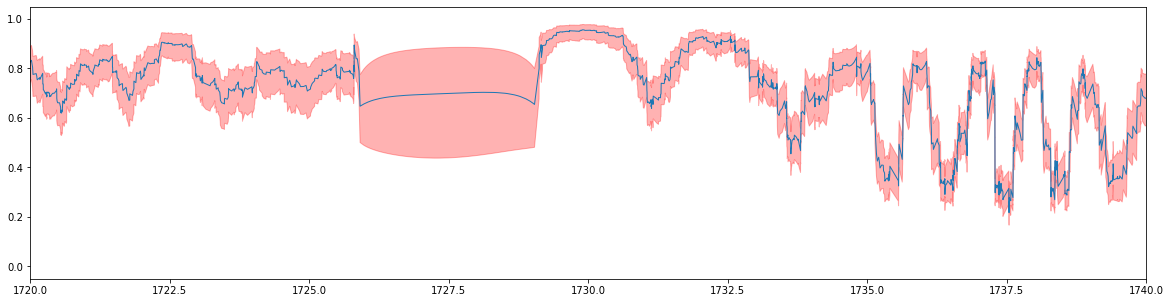

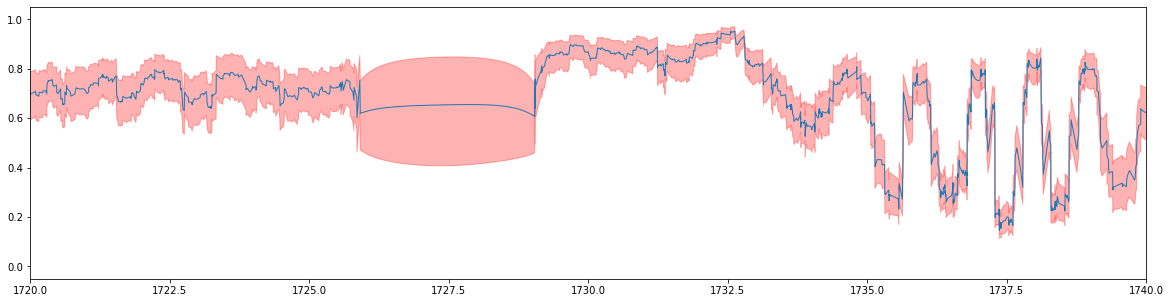

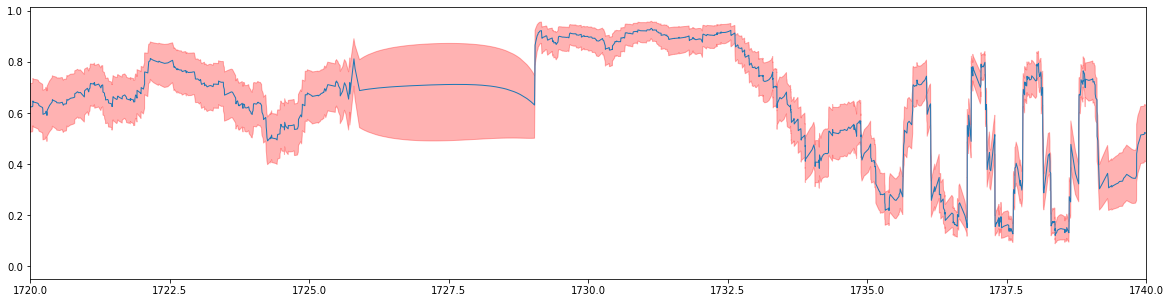

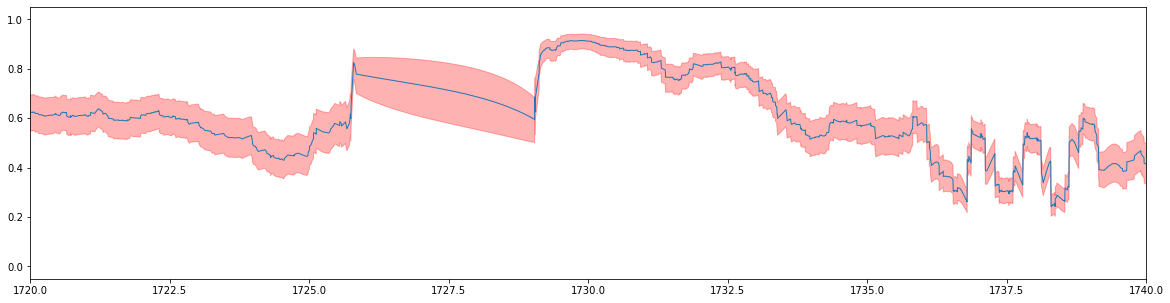

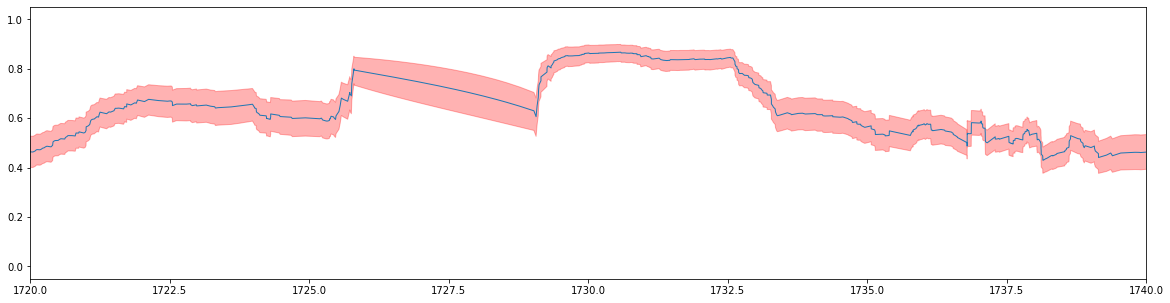

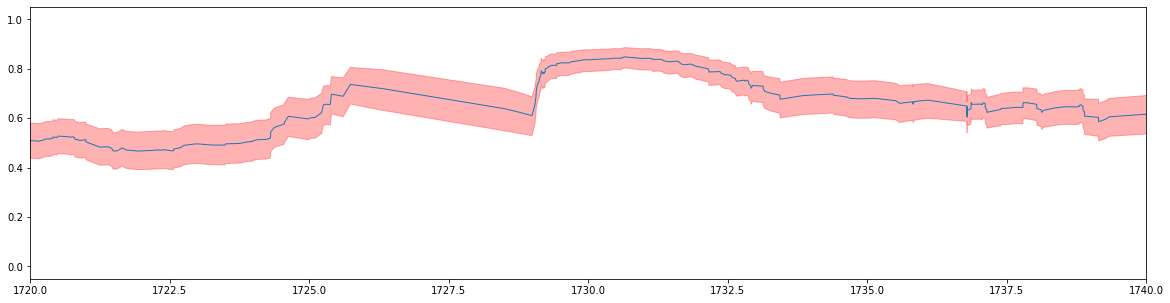

In [39]:
for _idx in inplay:
    plt.figure(figsize=(20,5))
    theta,kappa2 = rox['local_fractions_mean_'+str(_idx)], rox['local_fractions_variance_'+str(_idx)]
    plt.plot(np.array(times_glob[_idx]),\
         x_to_delfrac(theta),lw=1)
    plt.fill_between(np.array(times_glob[_idx]),\
                 y1=x_to_delfrac(theta-np.sqrt(kappa2)),y2=x_to_delfrac(theta+np.sqrt(kappa2)),lw=1,alpha=0.3,color = 'r')
    plt.xlim([1720,1740])

In [40]:
t = np.linspace(1700,2300,100000)
_values = np.zeros((N_sp,t.size))
for _idx in tqdm.tqdm_notebook(inplay):
    #print(_idx)
    _values[_idx] = np.interp(t,np.array(times_glob[_idx]),\
                              x_to_delfrac(reports['local_fractions_mean_'+str(_idx)][N_loop-1]))


/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/1206985959.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(inplay):


  0%|          | 0/19 [00:00<?, ?it/s]

In [41]:
_values

array([[0.95051193, 0.95050121, 0.95056221, ..., 0.95785887, 0.95794808,
        0.95800815],
       [0.96646727, 0.96962644, 0.97430456, ..., 0.94078008, 0.9175528 ,
        0.93539698],
       [0.94057412, 0.94003383, 0.93952018, ..., 0.95084066, 0.95112771,
        0.94978147],
       ...,
       [0.02269633, 0.02271825, 0.02274018, ..., 0.29440731, 0.29382623,
        0.3026213 ],
       [0.02648412, 0.02647206, 0.02645999, ..., 0.38896038, 0.38634983,
        0.37320246],
       [0.06082309, 0.06089163, 0.06096017, ..., 0.39958312, 0.39934086,
        0.3990986 ]])

In [42]:
x_to_delfrac(reports['local_fractions_mean_'+str(0)][N_loop-1])

array([8.18185797e-10, 9.45954426e-12, 1.06814557e-12, ...,
       9.35190814e-12, 8.12477419e-10, 1.35338956e-03])

(0.0, 1.0)

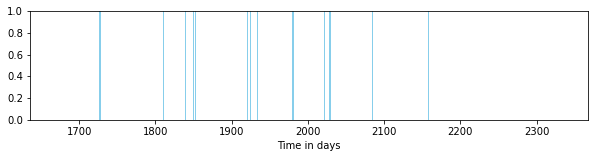

In [43]:
plt.figure(figsize=(10,2))
gap_list = get_gap_list(np.where(reports['global_gaps'][N_loop-1]<0.5)[0])
for _start,_end in gap_list:
    plt.fill_between([global_times[_start],global_times[_end]],y1=[0,0],y2=[1,1],color='skyblue',lw=0)
plt.xlabel('Time in days')
#plt.ylabel('Magnitude range of bin')
#plt.yticks(-0.5+np.arange(N_sp+1),g_labels,rotation=0);
plt.ylim([0,1])
#plt.savefig('./results/global_gaps.pdf',bbox_inches='tight',dpi=300)
#plt.savefig('./results/global_gaps.png',bbox_inches='tight',dpi=300)

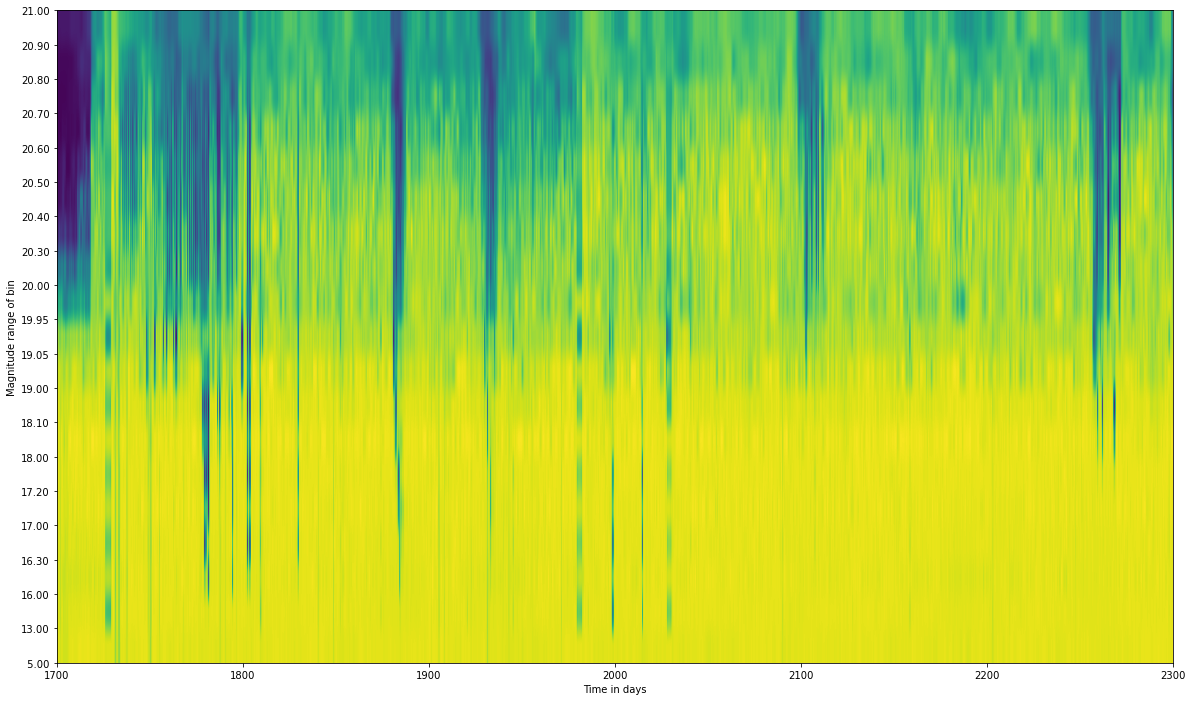

In [44]:
plt.figure(figsize=(20,12))
plt.imshow(_values,origin='lower',aspect='auto',extent=[1700,2300,-0.5,18.5])
plt.xlabel('Time in days')
plt.ylabel('Magnitude range of bin')
plt.yticks(-0.5+np.arange(N_sp+1),g_labels,rotation=0);
#plt.savefig('./results/deletion_rivers.pdf',bbox_inches='tight',dpi=300)
#plt.savefig('./results/deletion_rivers.png',bbox_inches='tight',dpi=300)

In [45]:
##### Load in scanning law
_data = pd.read_csv('path_to_scanning_law')
_columns = ['JulianDayNumberRefEpoch2010TCB@Gaia',
       'JulianDayNumberRefEpoch2010TCB@Barycentre_1',
       'JulianDayNumberRefEpoch2010TCB@Barycentre_2', 'ra_FOV_1(deg)',
       'dec_FOV_1(deg)', 'scanPositionAngle_FOV_1(deg)', 'ra_FOV_2(deg)',
       'dec_FOV_2(deg)', 'scanPositionAngle_FOV_2(deg)']
_keys = ['tcb_at_gaia','tcb_at_bary1','tcb_at_bary2','ra_fov_1','dec_fov_1','angle_fov_1','ra_fov_2','dec_fov_2','angle_fov_2']
scanninglaw_times = _data['JulianDayNumberRefEpoch2010TCB@Gaia'].values
del _data

In [46]:
global_times = np.concatenate([np.array(times_glob[_idx]) for _idx in inplay])
global_successes = np.concatenate([np.array(matches_glob[_idx]) for _idx in inplay])
global_spins = np.concatenate([np.repeat(_idx,np.array(times_glob[_idx]).size) for _idx in inplay])

GLOBAL_times = np.concatenate([global_times,scanninglaw_times])
GLOBAL_successes = np.concatenate([global_successes,-1*np.ones(scanninglaw_times.size)])
GLOBAL_spins = np.concatenate([global_spins,-1*np.ones(scanninglaw_times.size)])


GLOBAL_timesort = np.argsort(GLOBAL_times)
GLOBAL_times = GLOBAL_times[GLOBAL_timesort]
GLOBAL_dtimes = np.diff(GLOBAL_times)
GLOBAL_successes = GLOBAL_successes[GLOBAL_timesort]
GLOBAL_spins = GLOBAL_spins[GLOBAL_timesort]
unpack_box = {}
for _idx in inplay:
    unpack_box[_idx] = np.where((GLOBAL_spins == _idx) | (GLOBAL_spins == -1))
unpack_box[-1] = np.where((GLOBAL_spins == -1))
M = GLOBAL_times.size

In [47]:
sox = {'gaps':np.zeros(scanninglaw_times.size),'fractions':np.zeros((19,scanninglaw_times.size))} #if more than one bin 1->19

In [48]:
log_pi = np.array([np.log(0.5),np.log(0.5)])
log_A = np.zeros((2,2,M-1))
log_B = np.zeros((GLOBAL_times.size,2))
p = np.concatenate([x_to_delfrac(np.concatenate([rox['local_fractions_mean_'+str(_idx)] for _idx in inplay])),np.nan*np.ones(scanninglaw_times.size)])[GLOBAL_timesort]
_success = GLOBAL_successes==1
_failure = GLOBAL_successes==0
_scanninglaw = GLOBAL_successes==-1
log_B[_failure,0] = 0.0
log_B[_success,0] = -np.inf
log_B[_scanninglaw,0] = np.log(0.5)
log_B[_failure,1] = np.log(1.0-p[_failure]+1e-16)
log_B[_success,1] = np.log(p[_success]+1e-16)
log_B[_scanninglaw,1] = np.log(0.5)

args = (GLOBAL_successes,GLOBAL_dtimes,log_pi,log_A,log_B)

_F = 0.5
D_r = _F*(1.0-np.exp(-GLOBAL_dtimes/rox['r']))
D_q = (1.0-_F)*(1.0-np.exp(-GLOBAL_dtimes/rox['q']))
log_A[0,0] = np.log(1.0-D_r)
log_A[0,1] = np.log(D_r)
log_A[1,0] = np.log(D_q)
log_A[1,1] = np.log(1.0-D_q)
K=2

    
%time GLOBAL_gaps = continuous_viterbi(K,M,log_pi,log_A,log_B)[1]
sox['gaps'] = GLOBAL_gaps[unpack_box[-1]]

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/1832061228.py:21: RuntimeWarning: divide by zero encountered in log
  log_A[0,1] = np.log(D_r)
/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/1832061228.py:22: RuntimeWarning: divide by zero encountered in log
  log_A[1,0] = np.log(D_q)


CPU times: user 6.52 s, sys: 291 ms, total: 6.81 s
Wall time: 6.85 s


In [49]:
GLOBAL_gaps.shape

(25461450,)

In [50]:
_idx = 0
LOCAL_gaps = copy.copy(GLOBAL_gaps[unpack_box[_idx]])
LOCAL_times = copy.copy(GLOBAL_times[unpack_box[_idx]])
LOCAL_successes = copy.copy(GLOBAL_successes[unpack_box[_idx]])
LOCAL_spins = copy.copy(GLOBAL_spins[unpack_box[_idx]])
LOCAL_successes[LOCAL_gaps == 0.0] = -1

args = (LOCAL_times,LOCAL_successes,mu_prior,sigma2_prior,nu_prior,tau2_prior)


LOCAL_theta, LOCAL_kappa2, LOCAL_log_likelihood = forward_backward(LOCAL_times,LOCAL_successes,1.0,rox['l_'+str(_idx)],rox['eps2_'+str(_idx)],mu_prior,sigma2_prior,nu_prior,tau2_prior)
sox['fractions'][_idx] = x_to_delfrac(LOCAL_theta[LOCAL_spins<-0.5])

In [51]:
sox['fractions'][_idx]

array([1.06814557e-12, 1.06814557e-12, 1.06814557e-12, ...,
       8.12461376e-10, 8.12445555e-10, 1.35338950e-03])

In [52]:
mu_prior = -3.0
sigma2_prior = 36.0
nu_prior = -3.0
tau2_prior = 36.0
#sox['fractions'] = np.nan*np.ones((19,scanninglaw_times.size))
for _idx in tqdm.tqdm_notebook(inplay):

    LOCAL_gaps = copy.copy(GLOBAL_gaps[unpack_box[_idx]])
    LOCAL_times = copy.copy(GLOBAL_times[unpack_box[_idx]])
    LOCAL_successes = copy.copy(GLOBAL_successes[unpack_box[_idx]])
    LOCAL_spins = copy.copy(GLOBAL_spins[unpack_box[_idx]])
    LOCAL_successes[LOCAL_gaps == 0.0] = -1
    args = (LOCAL_times,LOCAL_successes,mu_prior,sigma2_prior,nu_prior,tau2_prior)

    LOCAL_theta, LOCAL_kappa2, LOCAL_log_likelihood = forward_backward(LOCAL_times,LOCAL_successes,1.0,rox['l_'+str(_idx)],rox['eps2_'+str(_idx)],mu_prior,sigma2_prior,nu_prior,tau2_prior)
    #LOCAL_theta, LOCAL_kappa2, LOCAL_log_likelihood = forward_backward(LOCAL_times,LOCAL_successes,1.0,1.0/4,rox['eps2_'+str(_idx)],mu_prior,sigma2_prior,nu_prior,tau2_prior)
    
    #while np.isnan(sox['fractions'][_idx,0])==True:
    #    print('Trying',_idx)
    sox['fractions'][_idx] = x_to_delfrac(LOCAL_theta[LOCAL_spins<-0.5])
    if np.isnan(sox['fractions'][_idx,0])==True:
        print('Failed',_idx)

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/13432425.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _idx in tqdm.tqdm_notebook(inplay):


  0%|          | 0/19 [00:00<?, ?it/s]

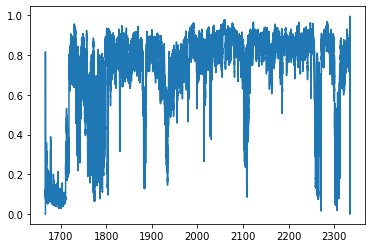

In [53]:
plt.plot(scanninglaw_times,sox['fractions'][13])

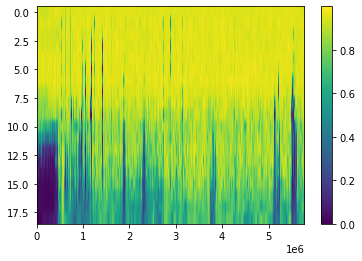

In [54]:
plt.imshow(sox['fractions'],aspect='auto')
plt.colorbar()

In [55]:
%%time
import h5py
with h5py.File("test_gaps_and_fractions_v1.h5", "w") as f:
    dset0 = f.create_dataset('times', data=scanninglaw_times, dtype='f8', compression="gzip", compression_opts=9)
    dset1 = f.create_dataset('gaps', data=sox['gaps'], dtype='i', compression="gzip", compression_opts=9,scaleoffset=0)
    dset2 = f.create_dataset('fractions', data=sox['fractions'], dtype='f', compression="gzip", compression_opts=9,scaleoffset=5)

CPU times: user 17.7 s, sys: 173 ms, total: 17.9 s
Wall time: 17.9 s


In [56]:
for _idx in inplay:
    print(sp_labels[_idx],'&','(%.2f,%.2f)'%(sp_bins[_idx],sp_bins[_idx+1]),'&','%i'%(F_deletion[_idx]*100),'&','%.2f'%rox['l_'+str(_idx)],'&','%.2f'%np.sqrt(rox['eps2_'+str(_idx)]),' \\\\')

SP1-1 & (5.00,13.00) & 0 & 149.97 & 1.53  \\
SP1-2 & (13.00,16.00) & 0 & 1.57 & 1.58  \\
SP1-3 & (16.00,16.30) & 1 & 9.62 & 1.47  \\
SP1-4 & (16.30,17.00) & 1 & 1.78 & 1.52  \\
SP1-5 & (17.00,17.20) & 2 & 7.02 & 1.52  \\
SP1-6 & (17.20,18.00) & 2 & 2.14 & 1.52  \\
SP1-7 & (18.00,18.10) & 2 & 11.04 & 1.51  \\
SP1-8 & (18.10,19.00) & 2 & 2.00 & 1.44  \\
SP1-9 & (19.00,19.05) & 2 & 7.01 & 1.31  \\
SP1-10 & (19.05,19.95) & 7 & 0.28 & 1.21  \\
SP1-11 & (19.95,20.00) & 2 & 7.82 & 1.00  \\
SP1-12 & (20.00,20.30) & 13 & 1.39 & 0.99  \\
SP1-13 & (20.30,20.40) & 12 & 2.31 & 1.08  \\
SP1-14 & (20.40,20.50) & 13 & 2.22 & 1.07  \\
SP1-15 & (20.50,20.60) & 28 & 2.50 & 1.02  \\
SP1-16 & (20.60,20.70) & 28 & 3.00 & 0.98  \\
SP1-17 & (20.70,20.80) & 28 & 8.80 & 0.84  \\
SP1-18 & (20.80,20.90) & 28 & 19.62 & 0.73  \\
SP1-19 & (20.90,21.00) & 24 & 14.88 & 0.63  \\


In [57]:
def time_to_obmt(_time):
    return 1717.6256+((_time+2455197.5 - 2457023.5 - 0.25)*4)

In [58]:
%%time
import h5py
with h5py.File("test_gaps_and_fractions_v1.h5", "r") as f:
    scanninglaw_times = f['times'][:]
    scanninglaw_gaps = f['gaps'][:]
    scanninglaw_fractions = f['fractions'][:]
probability_time_series = scanninglaw_fractions*scanninglaw_gaps[np.newaxis,:]

CPU times: user 2.51 s, sys: 276 ms, total: 2.78 s
Wall time: 2.77 s


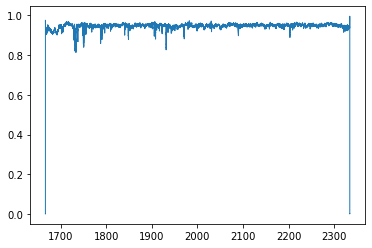

In [59]:
plt.plot(scanninglaw_times,scanninglaw_fractions[0],lw=1)

/var/folders/c9/f_9_mptn68q4271xp563257r0000gn/T/ipykernel_4137/802439524.py:38: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y = copy.copy(scanninglaw_gaps).astype(np.float)


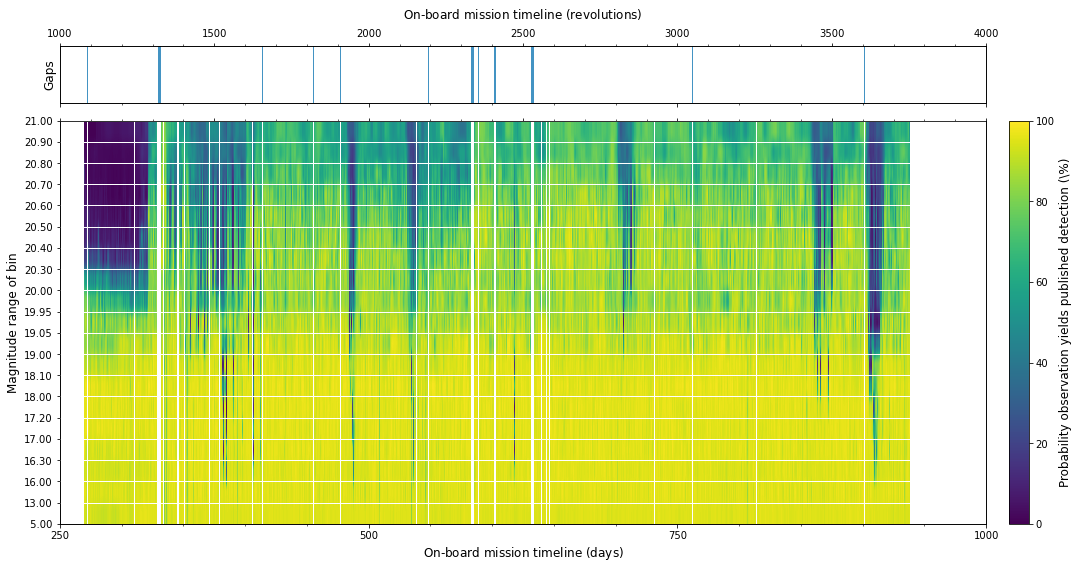

In [60]:
X = copy.copy(scanninglaw_fractions)
X[:,scanninglaw_gaps<0.5] = np.nan

#fig, ax1 = plt.figure(figsize=(10,6))
fig,ax1 = plt.subplots(figsize=(20,8))
im = ax1.imshow(X,origin='lower',aspect='auto',extent=[time_to_obmt(scanninglaw_times[0])/4,time_to_obmt(scanninglaw_times[-1])/4,-0.5,18.5])
ax1.set_xlabel('On-board mission timeline $(\mathrm{days})$',fontsize=12)
ax1.set_ylabel('Magnitude range of bin',fontsize=12)
ax1.set_xticks([250,500,750,1000])
ax1.set_yticks(-0.5+np.arange(N_sp+1))
ax1.set_yticklabels(g_labels,rotation=0);
ax1.minorticks_on()
ax1.tick_params(axis='y', which='minor', left=False)
cbar=fig.colorbar(im,pad=0.02)
cbar.set_label(r'Probability observation yields published detection (\%)',fontsize=12)
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1.0])
cbar.set_ticklabels([r'0',r'20',r'40',r'60',r'80',r'100'])
ax2 = plt.gca().twiny()
ax2.set_xlim([1000,4000])
ax2.minorticks_on()
for _yidx in np.arange(-0.5,18.6):
    ax2.plot([1000,4000],[_yidx,_yidx],c='w',lw=1)
ax2.set_ylim([-0.5,18.5])
ax2.xaxis.set_ticklabels([])

plt.subplots_adjust(bottom=0.1, right=0.9, top=0.8)
ax3 = plt.axes([0.125, 0.83, 0.76825-0.125, 0.1])
ax3.set_xticks([250,500,750,1000])

ax3.minorticks_on()
ax3.xaxis.set_ticklabels([])
ax3.yaxis.set_ticks([])
ax3.set_ylabel('Gaps',fontsize=12)
#gap_list = get_gap_list(np.where(scanninglaw_gaps<0.5)[0])
#for _start,_end in gap_list:
#    ax3.fill_between([time_to_obmt(scanninglaw_times[_start])/4,time_to_obmt(scanninglaw_times[_end+1])/4],y1=[0,0],y2=[1,1],color='skyblue',lw=0.5)
#ax3.imshow(scanninglaw_gaps.reshape((1,scanninglaw_gaps.size)),origin='lower',extent=[time_to_obmt(scanninglaw_times[0])/4,time_to_obmt(scanninglaw_times[-1])/4,0,1])
Y = copy.copy(scanninglaw_gaps).astype(np.float)
Y[Y==1.0] = np.nan
Y[Y==0.0] = 0.8
ax3.imshow(Y.reshape((1,Y.size)),cmap='RdBu',vmin=0,vmax=1,aspect='auto',origin='lower',extent=[time_to_obmt(scanninglaw_times[0])/4,time_to_obmt(scanninglaw_times[-1])/4,0,1])

ax3.set_xlim([250,1000])
ax4 = plt.gca().twiny()
ax4.set_xlim([1000,4000])
ax4.minorticks_on()
ax4.set_xlabel('On-board mission timeline $(\mathrm{revolutions})$',labelpad = 10,fontsize=12)

plt.show()
#plt.savefig('./results/deletion_rivers.pdf',bbox_inches='tight',dpi=300)
#plt.savefig('./results/deletion_rivers.png',bbox_inches='tight',dpi=300)